# Mock Generation Summer 2022
Author: Benjamin Floyd

In [1]:
import json
import emcee
import corner
import numpy as np
from astropy.table import Table, vstack
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

%matplotlib inline

# Set up rng
seed = 123
rng = np.random.default_rng(seed)
print(f'Using RNG seed: {seed}')

Using RNG seed: 123


### Mock generation functions

In [2]:
def poisson_point_process(model, dx, dy=None, lower_dx=0, lower_dy=0):
    """
    Uses a spatial Poisson point process to generate AGN candidate coordinates.

    Parameters
    ----------
    model : float
        The model rate used in the Poisson distribution to determine the number of points being placed.
    dx, dy : int, Optional
        Upper bound on x- and y-axes respectively. If only `dx` is provided then `dy` = `dx`.
    lower_dx, lower_dy : int, Optional
        Lower bound on x- and y-axes respectively. If not provided, a default of 0 will be used

    Returns
    -------
    coord : np.ndarray
        Numpy array of (x, y) coordinates of AGN candidates
    """

    if dy is None:
        dy = dx

    # Draw from Poisson distribution to determine how many points we will place.
    p = stats.poisson(model * np.abs(dx - lower_dx) * np.abs(dy - lower_dy)).rvs(random_state=rng)

    # Drop `p` points with uniform x and y coordinates
    x = rng.uniform(lower_dx, dx, size=p)
    y = rng.uniform(lower_dy, dy, size=p)

    # Combine the x and y coordinates.
    coord = np.vstack((x, y))

    return coord

In [3]:
def model_rate(params, radial_dist):
    """
    Our generating model.

    Parameters
    ----------
    params : tuple of floats
        Tuple of parameters.
    radial_dist : array-like
        A vector of radii of objects relative to the cluster center

    Returns
    -------
    model : np.ndarray
        A surface density profile of objects as a function of radius.
    """

    # Unpack the parameters
    theta, beta, c = params
    rc = rc_true

    # Our amplitude will eventually be more complicated
    a = theta

    # Our model rate is an amplitude of cluster-specific trends with a radial dependence with a constant background rate.
    model = a * (1 + (radial_dist / rc) ** 2) ** (-1.5 * beta + 0.5) + c

    return model

In [ ]:
def generate_mock_cluster(cluster_z: float, color_threshold: float, c_true: float) -> Table:
    # Background Catalog
    bkg_coords = poisson_point_process(c_true, dx=image_width)

    # Compute radial distances assuming the center of the image is the center of the cluster. In the future this will need to be generalized to the true cluster center.
    bkg_radii = np.sqrt((bkg_coords[0] - (image_width / 2))**2 + (bkg_coords[1] - (image_width / 2))**2)

    # Limit objects to within a max radius
    bkg_coords = bkg_coords[:, bkg_radii <= 2.5]
    bkg_radii = bkg_radii[bkg_radii <= 2.5]

    # Recast the SDWFS table as a Pandas Dataframe and use the sample method.
    sdwfs_agn_df = sdwfs_agn.to_pandas().sample(n=bkg_coords.shape[-1], weights=f'SELECTION_MEMBERSHIP_{color_threshold:.2f}', replace=True, random_state=rng)

    # Build a catalog of background information. For now, we will just grab the x,y coordinates, redshifts, completeness corrections, and selection memberships
    bkg_cat = Table([*bkg_coords, bkg_radii, sdwfs_agn_df['REDSHIFT'], sdwfs_agn_df['COMPLETENESS_CORRECTION'], sdwfs_agn_df[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']], names=['x', 'y', 'radial_dist', 'REDSHIFT', 'COMPLETENESS_CORRECTION', 'SELECTION_MEMBERSHIP'])

    # Add flag to background objects
    bkg_cat['CLUSTER_AGN'] = np.full_like(bkg_coords[0], False)

    # Cluster Catalog
    # Set an array of radii to generate model rates upon
    r_grid = np.linspace(0., 5., num=100)

    # Find the maximum rate of our model to use to for homogeneous Poisson process (Using c = 0.0 for a cluster-only model)
    max_rate = np.max(model_rate(params=(a_true, beta_true, 0.0), radial_dist=r_grid))

    # Generate the homogenous Poisson process (Again, this will need to be done on pixel units in the future.)
    cl_coords = poisson_point_process(max_rate, dx=image_width)

    # Calculate the radii from the image center
    cl_radii = np.sqrt((cl_coords[0] - (image_width / 2))**2 + (cl_coords[1] - (image_width / 2))**2)

    # Limit to a max radius
    cl_coords = cl_coords[:, cl_radii <= 2.5]
    cl_radii = cl_radii[cl_radii <= 2.5]

    # Compute model rates at each candidate position
    rate_at_radius = model_rate(params=(a_true, beta_true, 0.), radial_dist=cl_radii)

    # Perform rejection sampling
    prob_reject = rate_at_radius / max_rate
    alpha = rng.uniform(0., 1., size=len(rate_at_radius))
    cl_coords = cl_coords[:, prob_reject >= alpha]
    cl_radii = cl_radii[prob_reject >= alpha]

    # For the cluster, we need to select only objects within a redshift range of the cluster redshift.
    sdwfs_agn_at_z = sdwfs_agn[np.abs(sdwfs_agn['REDSHIFT'] - cluster_z) <= redshift_uncert]

    # Sample objects from the catalog.
    sdwfs_agn_at_z_df = sdwfs_agn_at_z.to_pandas().sample(n=cl_coords.shape[-1], weights=f'SELECTION_MEMBERSHIP_{color_threshold:.2f}', replace=True, random_state=rng)

    # Build catalog for cluster sources
    cl_cat = Table([*cl_coords, cl_radii, sdwfs_agn_at_z_df['REDSHIFT'], sdwfs_agn_at_z_df['COMPLETENESS_CORRECTION'], sdwfs_agn_at_z_df[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']], names=['x', 'y', 'radial_dist', 'REDSHIFT', 'COMPLETENESS_CORRECTION', 'SELECTION_MEMBERSHIP'])

    # Add flag to cluster objects
    cl_cat['CLUSTER_AGN'] = np.full_like(cl_coords[0], True)

    # Merge the catalogs
    los_cat = vstack([cl_cat, bkg_cat])
    return los_cat

### Bayesian model functions

In [4]:
def lnlike(params: tuple[float, ...]):
    # params = (0., params[0])

    # Compute the model rate at locations of the AGN.
    ri = master_catalog['radial_dist']
    ni = model_rate(params, ri)

    # Compute the ideal model rate at continuous locations
    rall = np.linspace(0., 2.5, num=10_000)
    nall = model_rate(params, rall)

    # We use a Poisson likelihood function
    ln_like_func = np.sum(np.log(ni * ri)) - np.trapz(nall * 2 * np.pi * rall, rall)

    return ln_like_func

In [5]:
def lnprior(params: tuple[float, ...]):
    # Extract the parameters
    theta, beta, c = params
    rc = rc_true

    h_c = c_truths[0]
    h_c_err = 0.018

    # Define parameter ranges
    if (0. <= theta <= np.inf and
        -3. <= beta <= 3. and
        0. <= rc <= 0.5 and
        0. <= c <= np.inf):
        theta_lnprior = 0.
        beta_lnprior = 0.
        rc_lnprior = 0.
        c_lnprior = -0.5 * np.sum((c - h_c) ** 2 / h_c_err ** 2)
    else:
        theta_lnprior = -np.inf
        beta_lnprior = -np.inf
        rc_lnprior = -np.inf
        c_lnprior = -np.inf

    total_lnprior = theta_lnprior + beta_lnprior + rc_lnprior + c_lnprior
    return total_lnprior

In [6]:
def lnprob(params: tuple[float, ...]):
    # Evaluate log-prior and test if we are within bounds
    lp = lnprior(params)

    if not np.isfinite(lp):
        return -np.inf

    return lnlike(params) + lp

## Generate mock catalog

In [8]:
# Read in the SDWFS IRAGN catalog for use later
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')

# Read in the purity and surface density files
with (open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f,
      open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_background_prior_distributions.json', 'r') as g):
    sdwfs_purity_data = json.load(f)
    sdwfs_prior_data = json.load(g)

# Set up interpolators
agn_purity_color = interp1d(sdwfs_purity_data['redshift_bins'][:-1], sdwfs_purity_data['purity_90_colors'], kind='previous')
agn_surf_den = interp1d(sdwfs_prior_data['color_thresholds'][:-1], sdwfs_prior_data['agn_surf_den'], kind='previous')
agn_surf_den_err = interp1d(sdwfs_prior_data['color_thresholds'][:-1], sdwfs_prior_data['agn_surf_den_err'], kind='previous')

# For convenience, set up the function compositions
def agn_prior_surf_den(redshift: float) -> float:
    return agn_surf_den(agn_purity_color(redshift))

def agn_prior_surf_den_err(redshift: float) -> float:
    return agn_surf_den_err(agn_purity_color(redshift))

In [7]:
# Our cluster will be at a redshift of z = 0.6 with a maximum deviation of +-0.03.
cluster_redshifts = [0.5, 0.6]
redshift_uncert = 0.03

# For a cluster at z = 0.6, the color threshold will be [3.6] - [4.5] = 0.61
color_thresholds = [agn_purity_color(z) for z in cluster_redshifts]

# For now, we will set a fixed window size of 5'x5'. This will need to be generalized to use the mask files' WCS.
image_width = 5.

# We'll boost the number of objects in our sample by duplicating this cluster by a factor.
num_clusters = 50

# We will set our input (true) parameters to be an arbitrary value for cluster and using an approximation of the expected background surface density using our color threshold.
a_true = 2.5
beta_true = 1.0
rc_true = 0.1
c_truths = np.array([agn_prior_surf_den(z) for z in cluster_redshifts])

# We will amplify the true parameters by the number of clusters in the sample.
a_true *= num_clusters
c_truths *= num_clusters
print(f'Input parameters: {a_true = }, {beta_true = }, {rc_true = }, {c_truths = }')

Input parameters: a_true = 250.0, beta_true = 1.0, rc_true = 0.1, c_true = 75.0


### Run cluster realization pipeline

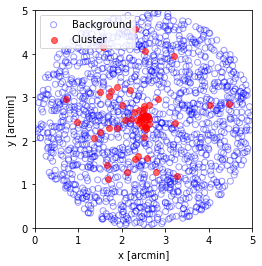

In [15]:
cluster_cats = []
for cluster_redshift, cluster_color_threshold, bkg_rate_true in zip(cluster_redshifts, color_thresholds, c_truths):
    cat = generate_mock_cluster(cluster_redshift, cluster_color_threshold, bkg_rate_true)
    cluster_cats.append(cat)

    # Show plot of combined line-of-sight positions
    cluster_objects = cat[cat['CLUSTER_AGN'].astype(bool)]
    background_objects = cat[~cat['CLUSTER_AGN'].astype(bool)]
    _, ax = plt.subplots()
    ax.scatter(background_objects['x'], background_objects['y'], edgecolors='blue', facecolors='none', alpha=0.4, label='Background')
    ax.scatter(cluster_objects['x'], cluster_objects['y'], edgecolors='red', facecolors='red', alpha=0.6, label='Cluster')
    ax.legend()
    ax.set(title=f'Cluster at z = {cluster_redshift}', xlabel='x [arcmin]', ylabel='y [arcmin]', xlim=[0, image_width], ylim=[0, image_width], aspect=1)
    plt.show()

# Combine all catalogs
master_catalog = vstack(cluster_cats)

## Apply Bayesian model to refit data

In [16]:
# Set up walkers
ndim = 3
nwalkers = 50
nsteps = 5000

# Initialize walker positions
# pos0 = np.array([rng.normal(a_true, 1e-4, size=nwalkers), rng.normal(beta_true, 1e-4, size=nwalkers), rng.normal(rc_true, 1e-4, size=nwalkers), rng.normal(c_true, 1e-4, size=nwalkers)]).T
pos0 = np.array([rng.normal(a_true, 1e-4, size=nwalkers), rng.normal(beta_true, 1e-4, size=nwalkers), rng.normal(c_truths[0], 1e-4, size=nwalkers)]).T

sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=lnprob)
sampler.run_mcmc(pos0, nsteps=nsteps, progress=True)

print(f'Mean autocorrelation time: {(mean_tau := np.mean(sampler.get_autocorr_time())):.2f} steps\n', f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}')

100%|██████████| 5000/5000 [01:54<00:00, 43.51it/s]

Mean autocorrelation time: 42.06 steps
 Mean acceptance fraction: 0.631


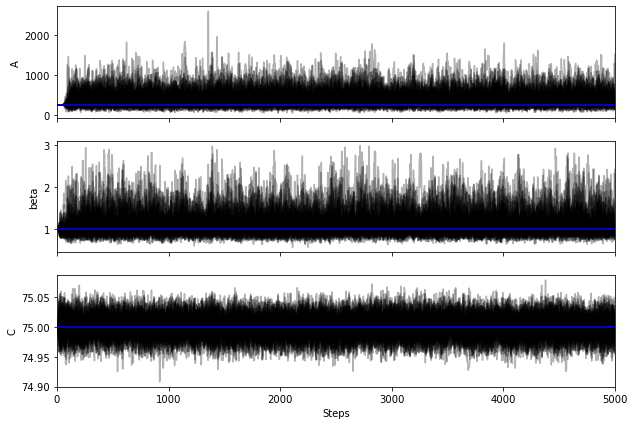

In [17]:
# Plot chains
samples = sampler.get_chain()
labels = ['A', 'beta', 'C']
truths = [a_true, beta_true, c_truths[0]]
_, axes = plt.subplots(nrows=ndim, figsize=(10, 7), sharex='col')
for i, (ax, label, truth) in enumerate(zip(axes.flatten(), labels, truths)):
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.axhline(y=truth, c='b')
    ax.set(ylabel=label, xlim=[0, len(samples)])
axes[-1].set(xlabel='Steps')
plt.show()

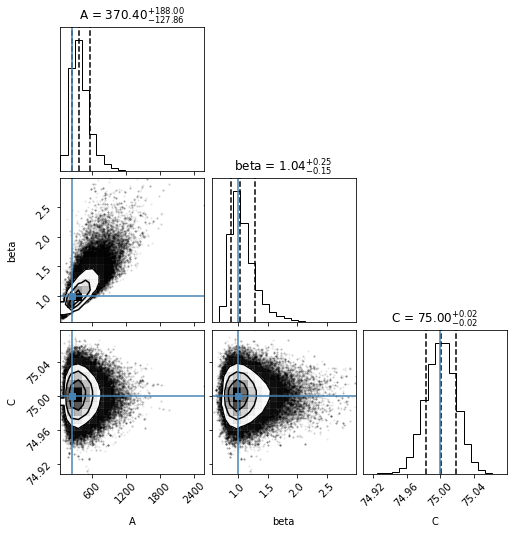

In [18]:
# Plot posterior
flat_samples = sampler.get_chain(discard=int(3*100), flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=truths, show_titles=True, quantiles=[0.16, 0.5, 0.84])